# Gradient Descent and Stochastic Gradient Descent

:label:`chapter_gd_sgd`


In this section, we are going to introduce the basic principles of gradient descent. Although it is not common for gradient descent to be used directly in deep learning, an understanding of gradients and the reason why the value of an objective function might decline when updating the independent variable along the opposite direction of the gradient is the foundation for future studies on optimization algorithms. Next, we are going to introduce stochastic gradient descent (SGD).

## Gradient Descent in One-Dimensional Space

Here, we will use a simple gradient descent in one-dimensional space as an
example to explain why the gradient descent algorithm may reduce the value of
the objective function. We assume that the input and output of the continuously
differentiable function $f: \mathbb{R} \rightarrow \mathbb{R}$ are both
scalars. Given $\epsilon$ with a small enough absolute value, according to the
Taylor's expansion formula from :numref:`chapter_math`, we get the following
approximation:

$$f(x + \epsilon) \approx f(x) + \epsilon f'(x) .$$

Here, $f'(x)$ is the gradient of function $f$ at $x$. The gradient of a one-dimensional function is a scalar, also known as a derivative.

Next, find a constant
$\eta>0$,
to make $\left|\eta f'(x)\right|$ sufficiently small
so that we can replace $\epsilon$ with
$-\eta f'(x)$
and get

$$f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.$$

If the derivative $f'(x) \neq 0$, then $\eta f'(x)^2>0$, so

$$f(x - \eta f'(x)) \lesssim f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in the gradient descent, we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the value of $f'(x)^2$ is small enough or the number of iterations has reached a certain value.

Now we will use the objective function $f(x)=x^2$ as an example to see how gradient descent is implemented. Although we know that $x=0$ is the solution to minimize $f(x)$, here we still use this simple function to observe how $x$ is iterated. First, import the packages or modules required for the experiment in this section.

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import math
from mxnet import nd
import numpy as np

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ 10 times, we can see that, eventually, the value of $x$ approaches the optimal solution.

In [2]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x* the derivative of x is f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


The iterative trajectory of the independent variable $x$ is plotted as follows.

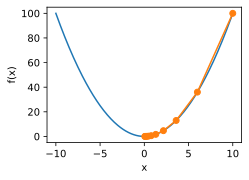

In [3]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line, [x * x for x in f_line])
    d2l.plt.plot(res, [x * x for x in res], '-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')

show_trace(res)

## Learning Rate

The positive $\eta$ in the above gradient descent algorithm is usually called the learning rate. This is a hyper-parameter and needs to be set manually. If we use a learning rate that is too small, it will cause $x$ to update at a very slow speed, requiring more iterations to get a better solution. Here, we have the iterative trajectory of the independent variable $x$ with the learning rate $\eta=0.05$. As we can see, after iterating 10 times when the learning rate is too small, there is still a large deviation between the final value of $x$ and the optimal solution.

epoch 10, x: 3.4867844009999995


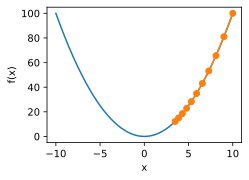

In [4]:
show_trace(gd(0.05))

If we use an excessively high learning rate, $\left|\eta f'(x)\right|$ might be too large for the first-order Taylor expansion formula mentioned above to hold. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$. For example, when we set the learning rate to $\eta=1.1$, $x$ overshoots the optimal solution $x=0$ and gradually diverges.

epoch 10, x: 61.917364224000096


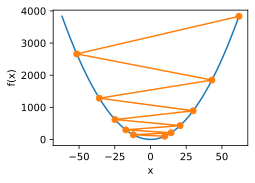

In [5]:
show_trace(gd(1.1))

## Gradient Descent in Multi-Dimensional Space

Now that we understand gradient descent in one-dimensional space, let us consider a more general case: the input of the objective function is a vector and the output is a scalar. We assume that the input of the target function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ is the $d$-dimensional vector $\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$. The gradient of the objective function $f(\boldsymbol{x})$ with respect to $\boldsymbol{x}$ is a vector consisting of $d$ partial derivatives:

$$\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.$$

For brevity, we use $\nabla f(\boldsymbol{x})$ instead of $\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$. Each partial derivative element $\partial f(\boldsymbol{x})/\partial x_i$ in the gradient indicates the rate of change of $f$ at $\boldsymbol{x}$ with respect to the input $x_i$. To measure the rate of change of $f$ in the direction of the unit vector $\boldsymbol{u}$ ($\|\boldsymbol{u}\|=1$), in multivariate calculus, the directional derivative of $f$ at $\boldsymbol{x}$ in the direction of $\boldsymbol{u}$ is defined as

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.$$

According to the property of directional derivatives, the aforementioned directional derivative can be rewritten as

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.$$

The directional derivative $\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$ gives all the possible rates of change for $f$ along $\boldsymbol{x}$. In order to minimize $f$, we hope to find the direction the will allow us to reduce $f$ in the fastest way. Therefore, we can use the unit vector $\boldsymbol{u}$ to minimize the directional derivative $\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$.

For $\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\|  \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\|  \cdot \text{cos} (\theta)$,
Here, $\theta$ is the angle between the gradient $\nabla f(\boldsymbol{x})$ and the unit vector $\boldsymbol{u}$. When $\theta = \pi$, $\text{cos }(\theta)$ gives us the minimum value $-1$. So when $\boldsymbol{u}$ is in a direction that is opposite to the gradient direction $\nabla f(\boldsymbol{x})$, the direction derivative $\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$ is minimized. Therefore, we may continue to reduce the value of objective function $f$ by the gradient descent algorithm:

$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).$

Similarly, $\eta$ (positive) is called the learning rate.

Now we are going to construct an objective function $f(\boldsymbol{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\boldsymbol{x} = [x_1, x_2]^\top$ as input and a scalar as the output. So we have the gradient $\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$. We will observe the iterative trajectory of independent variable $\boldsymbol{x}$ by gradient descent from the initial position $[-5,-2]$. First, we are going to define two helper functions. The first helper uses the given independent variable update function to iterate independent variable $\boldsymbol{x}$ a total of 20 times from the initial position $[-5,-2]$. The second helper will visualize the iterative trajectory of independent variable $\boldsymbol{x}$.

In [6]:
# This function is saved in the d2l package for future use
def train_2d(trainer):
    # s1 and s2 are states of the independent variable and will be used later
    # in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

# This function is saved in the d2l package for future use
def show_trace_2d(f, results):
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

Next, we observe the iterative trajectory of the independent variable at learning rate $0.1$. After iterating the independent variable $\boldsymbol{x}$ 20 times using gradient descent, we can see that. eventually, the value of $\boldsymbol{x}$ approaches the optimal solution $[0, 0]$.

epoch 20, x1 -0.057646, x2 -0.000073


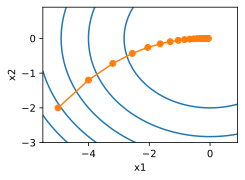

In [7]:
eta = 0.1

def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

## Stochastic Gradient Descent (SGD)

In deep learning, the objective function is usually the average of the loss functions for each example in the training data set. We assume that $f_i(\boldsymbol{x})$ is the loss function of the training data instance with $n$ examples, an index of $i$, and parameter vector of $\boldsymbol{x}$, then we have the objective function

$$f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x}).$$

The gradient of the objective function at $\boldsymbol{x}$ is computed as

$$\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}).$$

If gradient descent is used, the computing cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the model training data instance is large, the cost of gradient descent for each iteration will be very high.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots,n\}$ for data instances at random, and compute the gradient $\nabla f_i(\boldsymbol{x})$ to update $\boldsymbol{x}$:

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x}).$$

Here, $\eta$ is the learning rate. We can see that the computing cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. We should mention that the stochastic gradient $\nabla f_i(\boldsymbol{x})$ is the unbiased estimate of gradient $\nabla f(\boldsymbol{x})$.

$$\mathbb{E}_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it to gradient descent by adding random noise with a mean of 0 to the gradient to simulate a SGD.

epoch 20, x1 -0.331232, x2 -0.091303


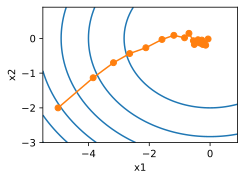

In [8]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

As we can see, the iterative trajectory of the independent variable in the SGD is more tortuous than in the gradient descent. This is due to the noise added in the experiment, which reduced the accuracy of the simulated stochastic gradient. In practice, such noise usually comes from individual examples in the training data set.


## Summary

* If we use a more suitable learning rate and update the independent variable in the opposite direction of the gradient, the value of the objective function might be reduced. Gradient descent repeats this update process until a solution that meets the requirements is obtained.
* Problems occur when the learning rate is tool small or too large. A suitable learning rate is usually found only after multiple experiments.
* When there are more examples in the training data set, it costs more to compute each iteration for gradient descent, so SGD is preferred in these cases.


## Exercises

* Using a different objective function, observe the iterative trajectory of the independent variable in gradient descent and the SGD.
* In the experiment for gradient descent in two-dimensional space, try to use different learning rates to observe and analyze the experimental phenomena.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2372)

![](../img/qr_gd-sgd.svg)